In [1]:
%matplotlib inline
import torch  as t
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.ndimage
import math
import os
from torch.autograd import Variable as V
import random

def affine_transform(input,mat):
    coor=coordinate_one()
    xyprime=t.tensordot(coor,t.t(mat),dims=1)
    return bilinear(input,xyprime)

def coordinate():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    return V(t.tensor(coor),True)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    onesMatrix = np.ones((xsize,ysize,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=2)
    return V(t.tensor(coorMatrix),True)

def nearest_neighbor(img,xyprime):
    xp=t.round(xyprime[:,:,0]).long()
    yp=t.round(xyprime[:,:,1]).long()
    xp=t.where(xp>xsize-1,t.tensor(xsize-1),xp)
    yp=t.where(yp>ysize-1,t.tensor(ysize-1),yp)
    return img[xp,yp]
    
def bilinear(img,xyprime):
    xp=xyprime[:,:,0]
    yp=xyprime[:,:,1]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUX=t.where(LUX>xsize-2,t.tensor(xsize-2),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1),LUX)
    LUY=t.where(LUY>ysize-2,t.tensor(ysize-2),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1),LUY)
    [a,b]=[yp-LUY.double(),xp-LUX.double()]
    [k00,k01,k10,k11]=[img[LUX,LUY],img[LUX,LUY+1],img[LUX+1,LUY],img[LUX+1,LUY+1]]
    return (1-b)*(a*k01+(1-a)*k00)+b*(a*k11+(1-a)*k10)   

def randxy(img,rate):
    zeros=t.zeros(img.shape)
    xsize,ysize=img.shape
    i=0
    while i<rate*xsize*ysize:
        randx=random.randint(0,xsize-1)
        randy=random.randint(0,ysize-1)
        if zeros[randx][randy]==0:
            i+=1
            zeros[randx][randy]=1
    return zeros
    
def imshow(img, mov, ref):
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("moving")
    
    plt.subplot(1,3,2)
    plt.imshow(mov)
    plt.title("after transformation")
    
    plt.subplot(1,3,3)
    plt.imshow(ref)
    plt.title("template")
    plt.show()



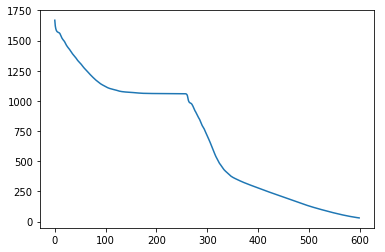

In [6]:
angle=5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
step=5e-8
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

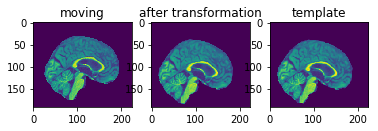

tensor(29.7754, dtype=torch.float64, grad_fn=<SumBackward0>)

In [7]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

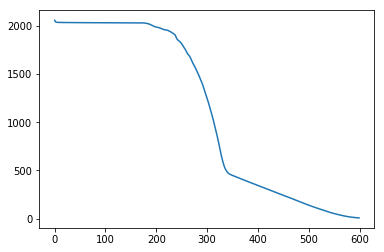

In [2]:
transformMatrix = V(t.Tensor([[0.9, -0.0, -0.0],[0.0, 0.9, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
step=5e-8
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err**2)   
    loss.backward(retain_graph=True)
    losses.append(loss)
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

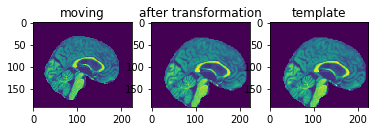

tensor(7.4774, dtype=torch.float64, grad_fn=<SumBackward0>)

In [3]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]